In [1]:
# make the main figure for the csu plot!

# functions used: make_plots_new_heights.py- crl plotting
# simple_flight_level_plot.py- in situ data plotting
# make_plots.plot_new_tdr()- tdr plotting

In [2]:
# import modules

import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import warnings

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import tc_metadata
import helper_fns
os.chdir("/Users/etmu9498/research/code/scripts/in-situ-scripts")
import in_situ_colorbar_lines
import sys
sys.path.append("/Users/etmu9498/research/code/scripts/plotting/")
import simple_flight_level_plot

In [3]:
### Helper functions 1 through 3 used to make this plot: plotting crl power

def plot_power_ch1( data_path, data_file):
    warnings.filterwarnings("ignore")
    # get data
    os.chdir( data_path)
    crl_data = xr.open_dataset( data_file)

    '''
    # choose x axis
    xaxis = crl_data.in_situ_distance
    # plot things
    plt.pcolormesh(  xaxis, - crl_data.H_new, crl_data.power_new.transpose(), vmin = -30, vmax =-10)
    '''
    
    # this is how to plot crl data using tdr scale! indicese were off by one in 2nd line
    xaxis = crl_data.tdr_distance
    plt.pcolormesh(  xaxis, - crl_data.H_new, crl_data.power_new.transpose()[:, 0:-1], vmin = -30, vmax =-10)

    plt.ylabel( 'Height (km)')    
    plt.colorbar(label="CRL Return Power ( dBz)")
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')
    warnings.filterwarnings("default")
    

def plot_T( data_path, data_file):
    warnings.filterwarnings("ignore")
    # get data
    os.chdir( data_path)
    new_crl = xr.open_dataset( data_file)
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    # choose x axis with helper script
    xaxis = crl_data.in_situ_distance

    plt.pcolormesh( xaxis, - new_crl.H_new, new_crl.T_new.transpose(), cmap = color_map, vmin=5, vmax=35 )
    plt.colorbar(label="CRL Temperature ( C)")

    plt.ylabel( 'Height (km)')
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')
    warnings.filterwarnings("default")


def plot_wvmr(data_path, data_file):
    # get data
    os.chdir( data_path)
    crl_data = xr.open_dataset( data_file)

    # choose x axis with helper script
    xaxis = crl_data.in_situ_distance

    # plot things
    plt.pcolormesh( xaxis, - crl_data.H_new, crl_data.wvmr_new.transpose(), vmin = 5, vmax =20)
    plt.colorbar(label="CRL WVMR ( g/kg)")
    plt.ylabel( 'Height (km)')
    plt.grid( 'on')
    ax = plt.gca()
    ax.set_facecolor('k')


In [4]:
def plot_tdr( tdr_path, tdr_name):
    warnings.filterwarnings("ignore")

    # get data
    os.chdir( tdr_path)
    tdr_data = xr.open_dataset( tdr_name)

    xaxis = tdr_data.distance
    
    # make plot
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    # plot data
    # get rid of nans and resize array to get rid of overlapping data
    # also, no need to use .transpose() because that was already done when making the datasets!
    reflectivity = tdr_data.REFLECTIVITY[ :, 0:len( xaxis)]
    # refl = tdr_data.REFLECTIVITY[:, lat_no_nan_ind] # another way?
    plt.pcolormesh( xaxis, tdr_data.height, reflectivity, cmap = color_map, vmin = -10, vmax = 50 )

    # making things prettier
    plt.colorbar( label="TDR Reflectivity (dBZ)")
    
    plt.ylabel( 'Height (Km)')
    plt.grid( 'on')
    warnings.filterwarnings("default")


In [5]:
### Helper function 5 used to plot in situ data


def plot_in_situ(crl_path, crl_name, tcdata, counter, xaxis='dist', plot_number=313):
    warnings.filterwarnings("ignore")

    in_situ_path = tcdata[ 'new_flight_data_path']
    in_situ_name = tc_metadata.choose_new_in_situ_name( tcdata['tc_name'], counter)

    # load in situ data
    os.chdir( in_situ_path)
    xr_in_situ = xr.open_dataset( in_situ_name)
    # load crl data to find the times corresponding to i1 and i2
    os.chdir( crl_path)
    crl_data = xr.open_dataset( crl_name)

    # crop in situ data
    # rename variables from xarray for convenience
    str_time = xr_in_situ.str_time
    float_time = xr_in_situ.float_time
    time1 = crl_data.time[ 0].values
    time2 = crl_data.time[ -1].values
    # find the in situ times nearest the crl times
    idx1 = (np.abs(float_time - time1)).argmin()
    idx2 = (np.abs(float_time - time2)).argmin()


    keyList = [ 'WS.d', 'UWZ.d', 'ASfmrRainRate.1', 'distance']
    # make an empty dict that will be filled soon!
    datatrim = {key: None for key in keyList}
    # fill dict with keys provided after editing data!
    for key in keyList:
        temp_var = empty_str_helper( xr_in_situ[key].values)
        temp_var = temp_var[ idx1.values : idx2.values]
        datatrim[ key] = temp_var



    # get the proper axis
    if xaxis == "time":
        xaxis_data = float_time
        xlabel = 'Time (UTC, Hours)'
    elif xaxis == "lon":
        xaxis_data = datatrim['LONref']
        xlabel = 'Longitude (Degrees)'
    elif xaxis == "lat":
        xaxis_data = datatrim['LATref']
        xlabel = 'Latitude (Degrees)'
    elif xaxis == 'dist':
        xaxis_data = datatrim['distance']
    else:
        print( "Please choose 'lon', 'lat', 'time', or 'dist' as a valid xaxis!")

    # make sure the x axis data is a numpy array for proper plotting
    xaxis_data = np.array(xaxis_data)

    #     ax1 = fig1[ 0].add_subplot( plot_number)
    fig = plt.gcf()
    ax1 = fig.add_subplot( plot_number)

    ax1.set_ylabel( 'Vertical Wind Speed (m/s)', c='y')
    ax1.set_xlabel( 'Distance from TC Center (km)')
    ax1.xaxis.grid( )
    ax1.yaxis.grid( )

    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Wind Speed (m/s)', c='c')
    
    ax3 = ax1.twinx()
    ax3.set_ylabel( 'SFMR Rain Rate (mm/hr)', c='b')
    ax3.spines.right.set_position(("axes", 1.1))

    # set y limits to separate plots nicely
    ax2.set_ylim([-60, 70])
    ax1.set_ylim([-20, 30])
    ax3.set_ylim([0, 100])
    

    # actually plot everything!
    ax2.plot( xaxis_data, datatrim['WS.d'], c='c', label='Tangential Wind Speed (m/s)')
    ax1.plot( xaxis_data, datatrim['UWZ.d'], c='y', label='Vertical Wind Speed ( m/s)')
    ax3.plot( xaxis_data, datatrim['ASfmrRainRate.1'], c='b', label=' SFMR Rain Rate (mm/hr)')

    # manually set y ticks?
    ax2.set_yticks([0,30,60])
    ax1.set_yticks([-10,0,10,20])
    ax3.set_yticks([0,20,40])

    # add an empty colorbar to make everything fit in line
    helper_fns.add_blank_colorbar()

    warnings.filterwarnings("ignore")
    
    
# turn all string values into floats
# this is a longer function to account for empty strings: turn those values into nans
def empty_str_helper( return_var):
    return_var_temp = np.zeros( len( return_var))
    count = 0
    for line_ind in range( len( return_var)):
        if return_var[ line_ind] == '':
            return_var_temp[line_ind] = np.nan
            count += 1
        else:
            return_var_temp[ line_ind] = float( return_var[ line_ind])
    return return_var_temp.tolist()

tdr plot added
crl power plot added
crl temp plot added
crl water vapor plot added
in situ plot added
figure saved


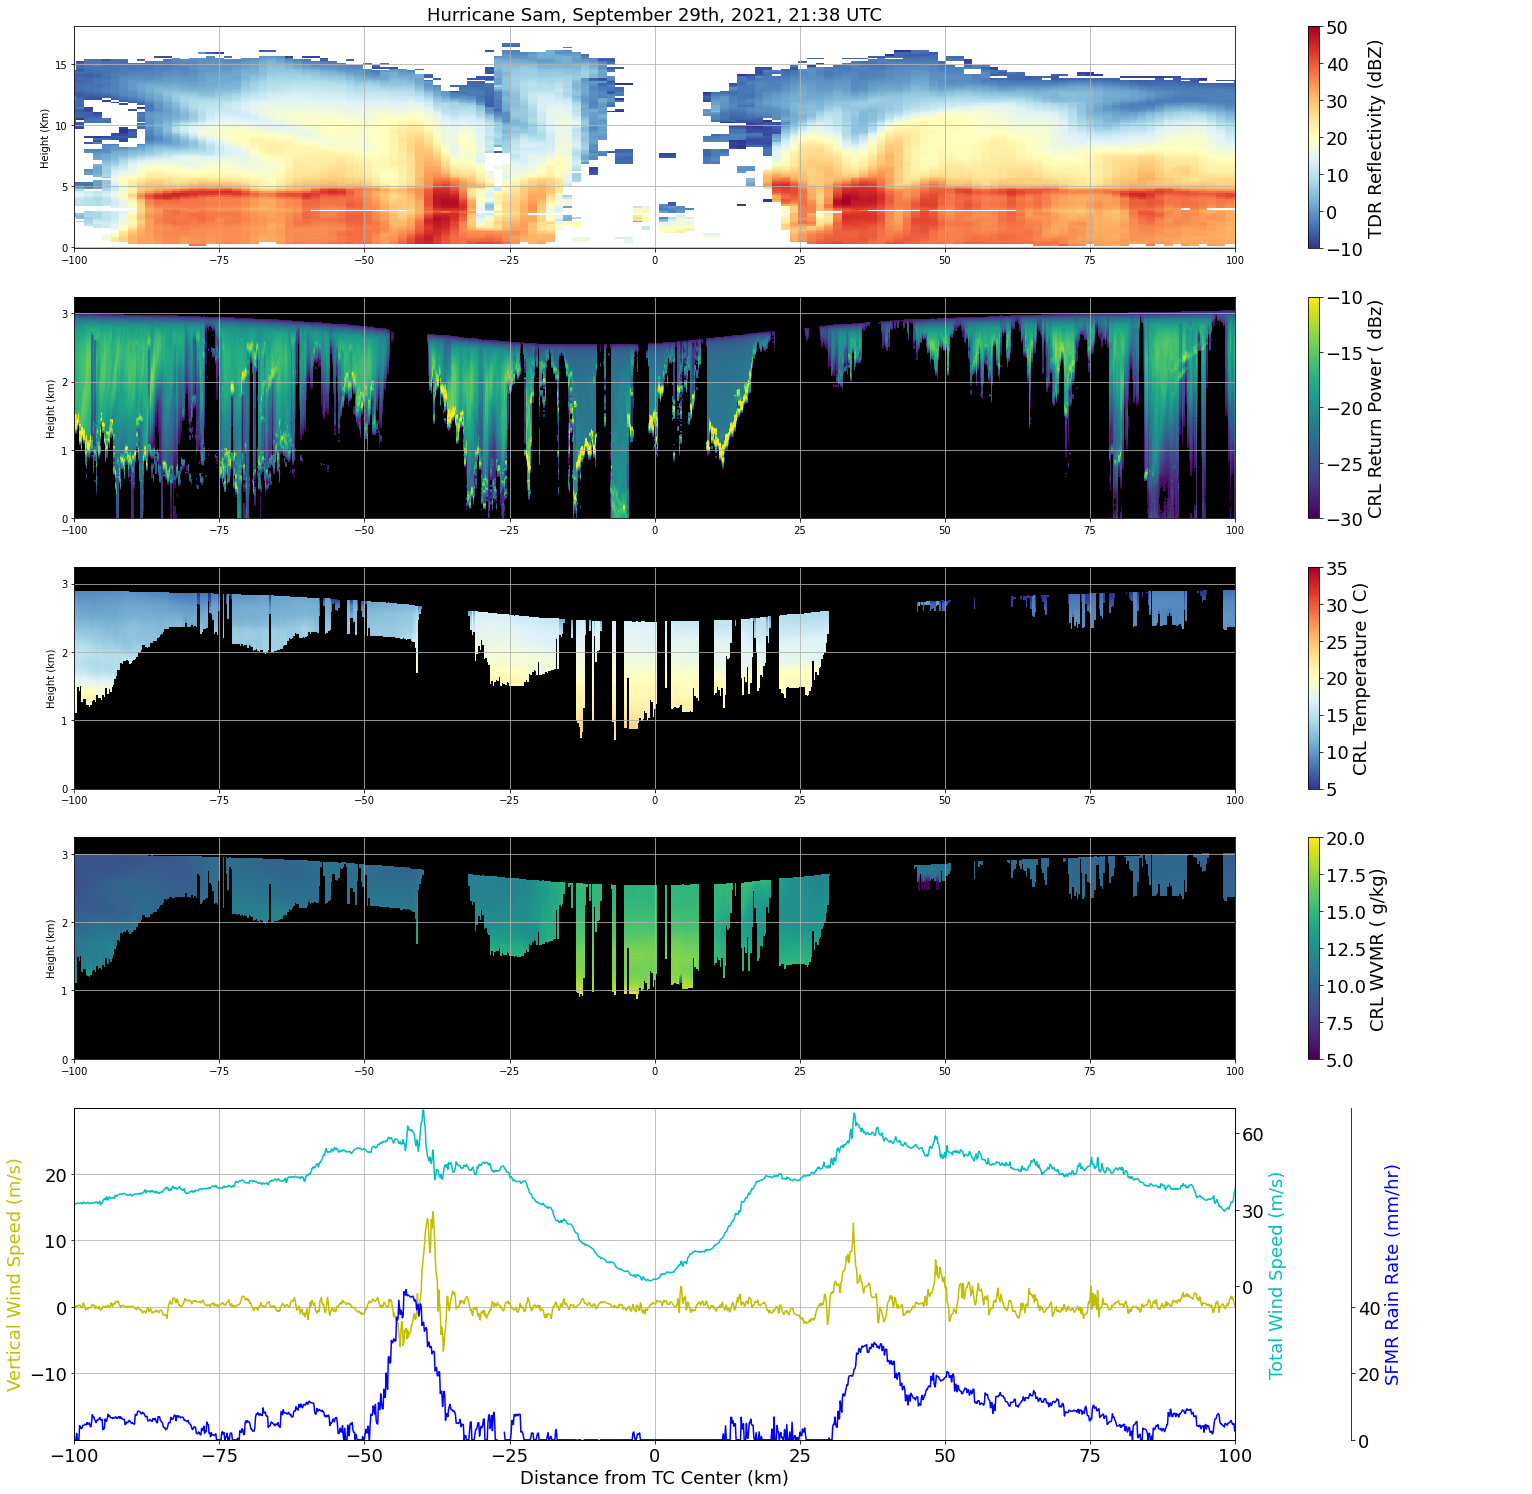

In [6]:
# set up metadata for sam 9/29 pass 1 case

tcname = 'sam'
metadata = tc_metadata.all_data( tcname)
dataset = 5
padding = 100 # amount of space on each side of tc center

# get the correct name of this day's dataset
crl_path = "/Users/etmu9498/research/data/crl-new-matrices"
tdr_path = "/Users/etmu9498/research/data/tdr-new"
tdr_name, crl_name = tc_metadata.choose_new_data( tcname, dataset)

# load data
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)

# initialize figure
warnings.filterwarnings("ignore")

fig1 = plt.subplots(5, 1, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1.5]}, figsize=(26, 26)) # , facecolor='w')

# fig = plt.figure( figsize=(26, 26)) # , facecolor='w') keep the facecolor blank for a nicer poster background
helper_fns.change_font_sizes(small=18, medium=18)

# create tdr plot
plt.subplot( 511)
plt.title( "Hurricane Sam, September 29th, 2021, 21:38 UTC", loc='center')
# plt.title( "Tail Doppler Radar (TDR) Data", loc='center')
plot_tdr( tdr_path, tdr_name)
plt.xlim( [ - padding, padding])

print('tdr plot added')

# plot crl power with in situ distance axis
plt.subplot(512)
plot_power_ch1(crl_path, crl_name) # use this local function, not the one found in make_plots_new_heights
plt.xlim( [ - padding, padding])
# plt.title( "Compact Raman Lidar (CRL) Data", loc='center')
plt.ylim( [ 0, crl_data.H_max + .1])

print( 'crl power plot added')


# plot crl temp with in situ distance axis
plt.subplot(513)
plot_T(crl_path, crl_name) # use this local function, not the one found in make_plots_new_heights
plt.xlim( [ - padding, padding])
# plt.title( "Compact Raman Lidar (CRL) Data", loc='center')
plt.ylim( [ 0, crl_data.H_max + .1])

print( 'crl temp plot added')


# plot crl wv with in situ distance axis
plt.subplot(514)
plot_wvmr( crl_path, crl_name) # use this local function, not the one found in make_plots_new_heights
plt.xlim( [ - padding, padding])
# plt.title( "Compact Raman Lidar (CRL) Data", loc='center')
plt.ylim( [ 0, crl_data.H_max + .1])

print( 'crl water vapor plot added')


# remove axes before plotting in situ data? to avoid overlaps
plt.subplot(515)
plt.grid(False)
plt.axis('off')

# plot in situ data
plot_in_situ( crl_path, crl_name, metadata, dataset, 'dist', plot_number = 515)
plt.xlim( [ - padding, padding])


print( 'in situ plot added')



os.chdir( "/Users/etmu9498/research/figures/csu-poster")
plt.savefig( "many_subplots.png", dpi=300 ) # bbox_inches='tight',

print( 'figure saved')
